## Lab 13b: Hidden Markov Model (HMM) of Risky Asset Price Timeseries

The objective of `Lab-13b` is to familiarize students with the structure of [Hidden Markov Model (HMM)](https://en.wikipedia.org/wiki/Hidden_Markov_model) models and thier application to time series simulation. 

#### Code setup

In [1]:
# install required packages
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/course_repos/CHEME-5660-Course-Repository-F23/labs/unit-3-labs/Lab-13b`
  No Changes to `~/Desktop/course_repos/CHEME-5660-Course-Repository-F23/labs/unit-3-labs/Lab-13b/Project.toml`
  No Changes to `~/Desktop/course_repos/CHEME-5660-Course-Repository-F23/labs/unit-3-labs/Lab-13b/Manifest.toml`


In [2]:
include("Include.jl");

In [3]:
# colors -
colors = Dict{Int,RGB}();
colors[1] = colorant"#0077BB";
colors[2] = colorant"#BBBBBB";
colors[3] = colorant"#EE7733";
colors[4] = colorant"#88CCEE";

In [4]:
colors[3]

#### Setup the transition and the emission matrices 

In [5]:
# Emission probability matrix -
EPM = [
    0.70 0.20 0.1 ;
    0.10 0.20 0.7 ;
];

In [6]:
# Transition matrix for the MC
P = [
    0.55 0.45;
    0.35 0.65;
];

#### Simulate the HMM

In [7]:
# Setup/initialize
number_of_hidden_states = 2
number_of_output_states = 3
number_of_simulation_steps = 480
emission_probability_dict = Dict{Int,Categorical}()
simulation_dict = Dict{Int,Int}()

# compute the stationary distribution for the MC -
π = iterate(P, 1;  maxcount = 10, ϵ = 0.001)[1,:] # assumption: iterate converges
mcd = Categorical(π); # Markov-chain distribution

# construct emission probability dictionary -
for i ∈ 1:number_of_hidden_states
    emission_probability_dict[i] = Categorical(EPM[i,:])
end

# PHASE 2: Simulation ----------------------------------------------------------------------------- #
for i ∈ 1:number_of_simulation_steps
    
    # which state is the mc in?
    hidden_state = rand(mcd);
    
    # grab the emission probability model from the emission_probability_dict -
    epd = emission_probability_dict[hidden_state];
    
    # role for a random ouput -
    simulation_dict[i] = rand(epd);
end

In [8]:
π

2-element Vector{Float64}:
 0.4375000000000005
 0.5625000000000007

#### Simulate the Price series

In [9]:
# set the number of sample paths
number_of_sample_paths = 100
archive = Dict{Int64, Array{Float64,1}}();

Sₒ = 100.0;
S = Array{Float64,2}(undef,number_of_simulation_steps, number_of_sample_paths)

for i ∈ 1:number_of_sample_paths
    
    # setup -
    S[1,i] = Sₒ
    
    # sim loop -
    for j ∈ 2:number_of_simulation_steps

        # generate random up and down moves -
        lb = 0.0;
        ub = 0.1; # in %
        μ = (1/100)*(lb + (ub - lb)*rand());
        Δ = [μ,0,-μ];

        # market state -
        market_state_index = simulation_dict[j-1]

        # get previous price -
        S[j,i] = S[j-1,i]*exp(Δ[market_state_index]);
    end
end

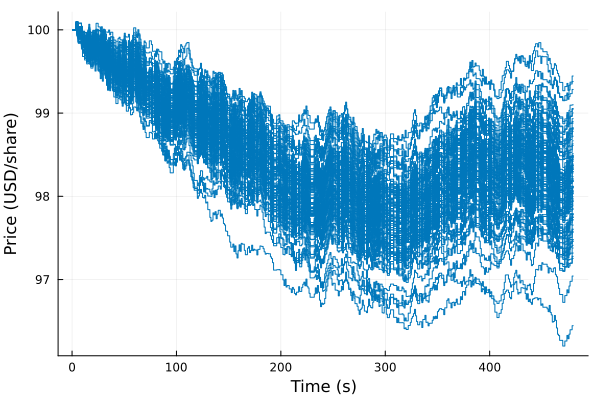

In [10]:
plot(S, label="", c=colors[1], linetype=:steppre)
xlabel!("Time (s)", fontsize=18)
ylabel!("Price (USD/share)", fontsize=18)

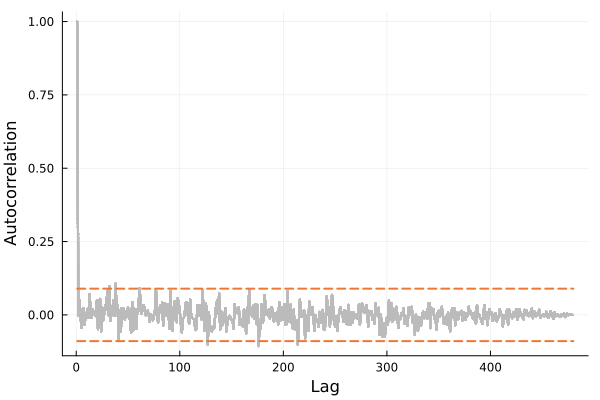

In [11]:
p = plot()
lags = range(0,step=1,stop=(number_of_simulation_steps - 2)) |> collect
for i ∈ 1:number_of_sample_paths

    # compute the return -
    return_vector = R(S[:,1]);
    AC = autocor(return_vector,lags);
    
    # plot -
    plot!(AC,lw=2, label="", c=colors[2])
end
current()

# plot the CI -
U = zeros(number_of_simulation_steps) .+ 1.96/sqrt(number_of_simulation_steps);
L = zeros(number_of_simulation_steps) .- 1.96/sqrt(number_of_simulation_steps);
plot!(U,lw=2,c=colors[3], label="", ls=:dash)
plot!(L,lw=2,c=colors[3], label="", ls=:dash)
xlabel!("Lag",fontsize=18)
ylabel!("Autocorrelation",fontsize=18)

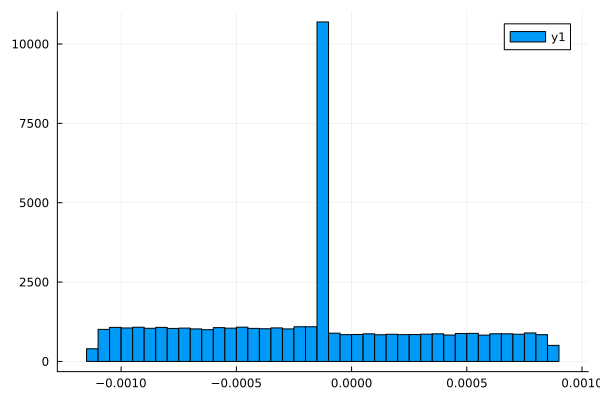

In [16]:
tmp = Array{Float64,1}()
for i ∈ 1:number_of_sample_paths
    
    tmp_return = R(S[:,i])
    for value ∈ tmp_return
        push!(tmp, value)
    end
end

histogram(tmp)